# Modelos para variable target binaria

## Imports y data load

In [35]:
# Standard library
import os
from datetime import datetime
from imblearn.pipeline import Pipeline
from pathlib import Path
import sys

# Data & Numerical
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna
from scipy.stats import uniform, randint

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, make_scorer, 
    precision_score, recall_score, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

In [36]:
# Add parent directory to path
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

# Custom imports
from scripts.results_analyzer import ResultsAnalyzer

In [37]:
data_path = '../data/base_procesada_binaria.csv'

#Constants

TARGET = 'target_binaria'

In [38]:
df_int_binario = pd.read_csv(data_path)
df_int_binario.head()

,Estudios_máximos_antes_de_la_inscripción,estado_civil,sexo,desplazado,Asistencia_diurna/nocturna,Cualificación_promedio_de_estudios_previos,Puntaje_en_examen_de_ingreso,Necesidades_educativas_especiales,Tiene_deuda,Pago_de_matrícula_al_día,...,Carrera_Gestión,Carrera_Ingeniería Informática,Carrera_Periodismo y Comunicación,Carrera_Psicología,Carrera_Publicidad y Marketing,Carrera_Química,Carrera_Sociología,Carrera_Turismo,Carrera_Veterinaria,target_binaria
0,3,1,0,0,1,66,65,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,1,0,1,1,69,66,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,3,1,0,1,1,69,63,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,1,1,68,68,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3,1,1,1,1,68,70,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [39]:
# Separar features y target
X = df_int_binario.drop(TARGET, axis=1)
y = df_int_binario[TARGET]

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Models

### Regresión logística

In [40]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])


param_grid = {
    'classifier__solver': ['liblinear', 'lbfgs', 'saga'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],  
    'classifier__penalty': ['l2'],  # l1 solo con liblinear/saga
    'classifier__class_weight': [None, 'balanced'] 
}

# Create GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train, y_train)


for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1-score en validación cruzada: {grid_search.best_score_:.4f}")


best_pipeline = grid_search.best_estimator_

y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)


accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
classifier__C: 0.1
classifier__class_weight: balanced
classifier__penalty: l2
classifier__solver: lbfgs

Mejor F1-score en validación cruzada: 0.8082



RESULTADOS EN TEST SET - LOGISTIC REGRESSION
Accuracy:  0.8548
Precision: 0.8065
Recall:    0.8124
F1-Score:  0.8094
ROC-AUC:   0.9184

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7137
           1       0.81      0.81      0.81      4365

    accuracy                           0.85     11502
   macro avg       0.85      0.85      0.85     11502
weighted avg       0.86      0.85      0.85     11502



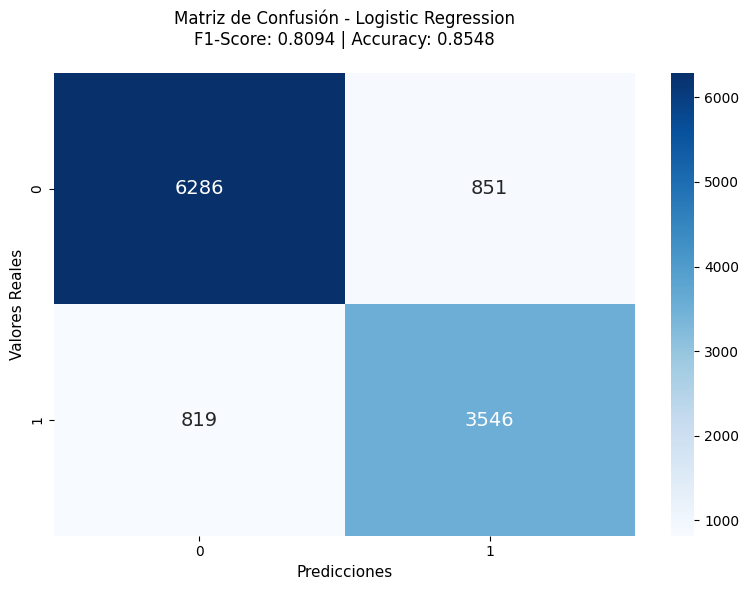

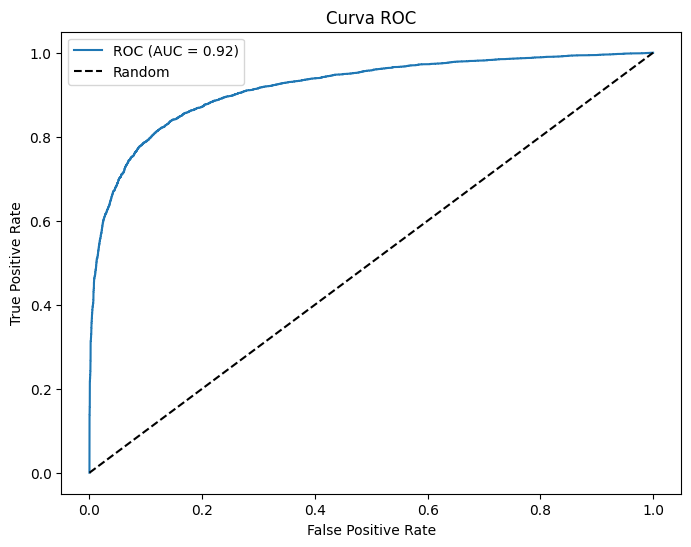

In [41]:
analyzer = ResultsAnalyzer()
results_df = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Logistic Regression")


In [42]:
results_df.head()

,Modelo,Hiperparametros,Accuracy,F1_Score,Precision,Recall,ROC_AUC,CV_F1_Mean,CV_F1_Std,Fecha
0,Logistic Regression,"{'classifier__C': 0.1, 'classifier__class_weig...",0.8548,0.8094,0.8065,0.8124,0.9184,0.8082,0.002,2025-10-17 15:19:15


Pipeline detectado. Usando: LogisticRegression
Modelo multiclase: 2 clases
Clases: [0 1]


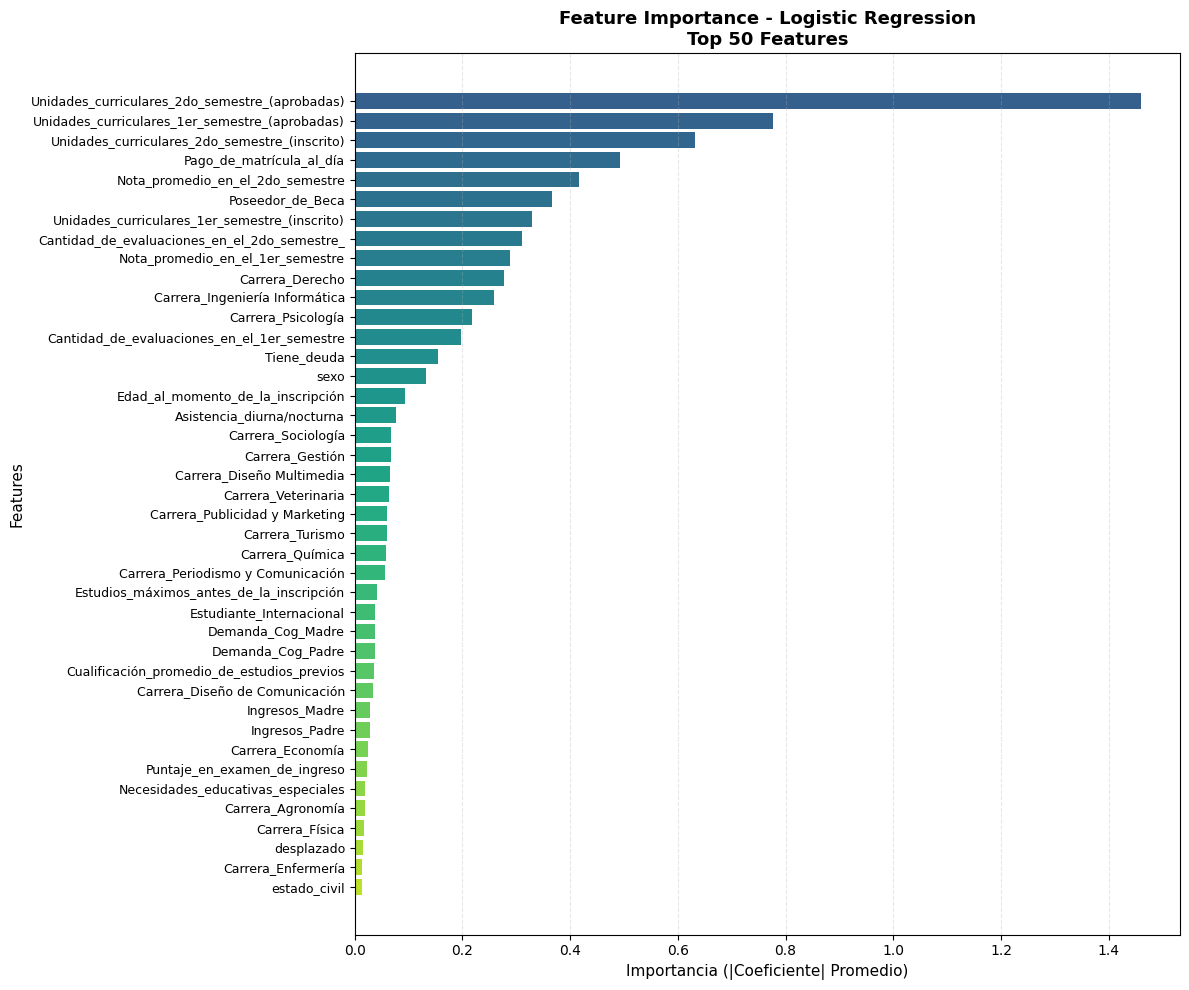


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    1.459346
Unidades_curriculares_1er_semestre_(aprobadas)    0.777191
 Unidades_curriculares_2do_semestre_(inscrito)    0.631050
                      Pago_de_matrícula_al_día    0.493082
              Nota_promedio_en_el_2do_semestre    0.415911
                              Poseedor_de_Beca    0.366474
 Unidades_curriculares_1er_semestre_(inscrito)    0.328895
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.310342
              Nota_promedio_en_el_1er_semestre    0.289053
                               Carrera_Derecho    0.277584
                Carrera_Ingeniería Informática    0.258321
                            Carrera_Psicología    0.218491
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.197745
                                   Tiene_deuda    0.155397
                                          sexo    0.131473
             Edad_al_momento_de_la_ins

In [43]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_pipeline,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10)
)

### Logistic Regression con SMOTE

In [44]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])


param_grid = {
    'classifier__solver': ['liblinear', 'lbfgs', 'saga'],
    'classifier__C': [0.01, 0.1, 1, 10, 50],
    'classifier__penalty': ['l2'],
    'classifier__class_weight': [None, 'balanced'] 
}

#GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train_smote, y_train_smote)


print("\nMejores parámetros:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1-score en validación cruzada: {grid_search.best_score_:.4f}")


best_pipeline = grid_search.best_estimator_

y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Mejores parámetros:
classifier__C: 0.1
classifier__class_weight: None
classifier__penalty: l2
classifier__solver: saga

Mejor F1-score en validación cruzada: 0.8632



RESULTADOS EN TEST SET - LOGISTIC REGRESSION CON SMOTE
Accuracy:  0.8585
Precision: 0.8419
Recall:    0.7721
F1-Score:  0.8054
ROC-AUC:   0.9175

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      7137
           1       0.84      0.77      0.81      4365

    accuracy                           0.86     11502
   macro avg       0.85      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



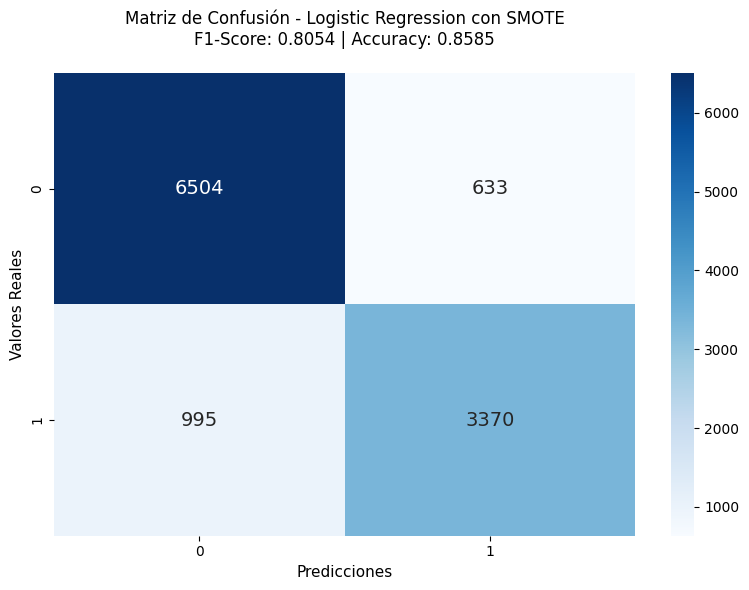

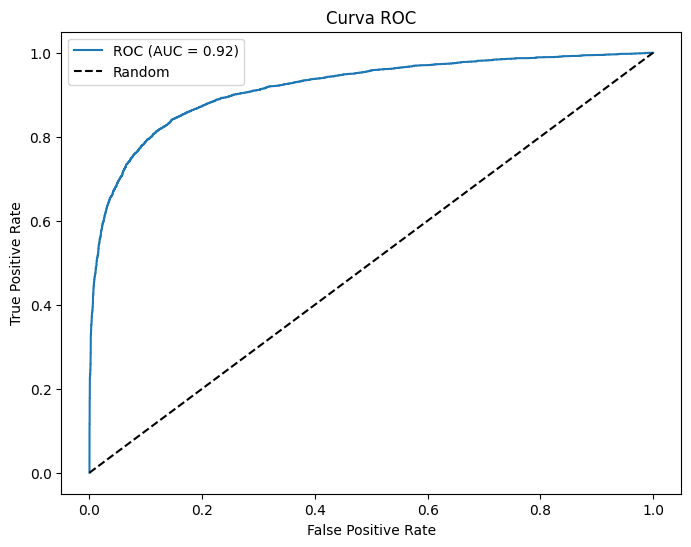

In [45]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Logistic Regression con SMOTE")

In [46]:
results_df = pd.concat([results_df, results], ignore_index=True)

Pipeline detectado. Usando: LogisticRegression
Modelo multiclase: 2 clases
Clases: [0 1]


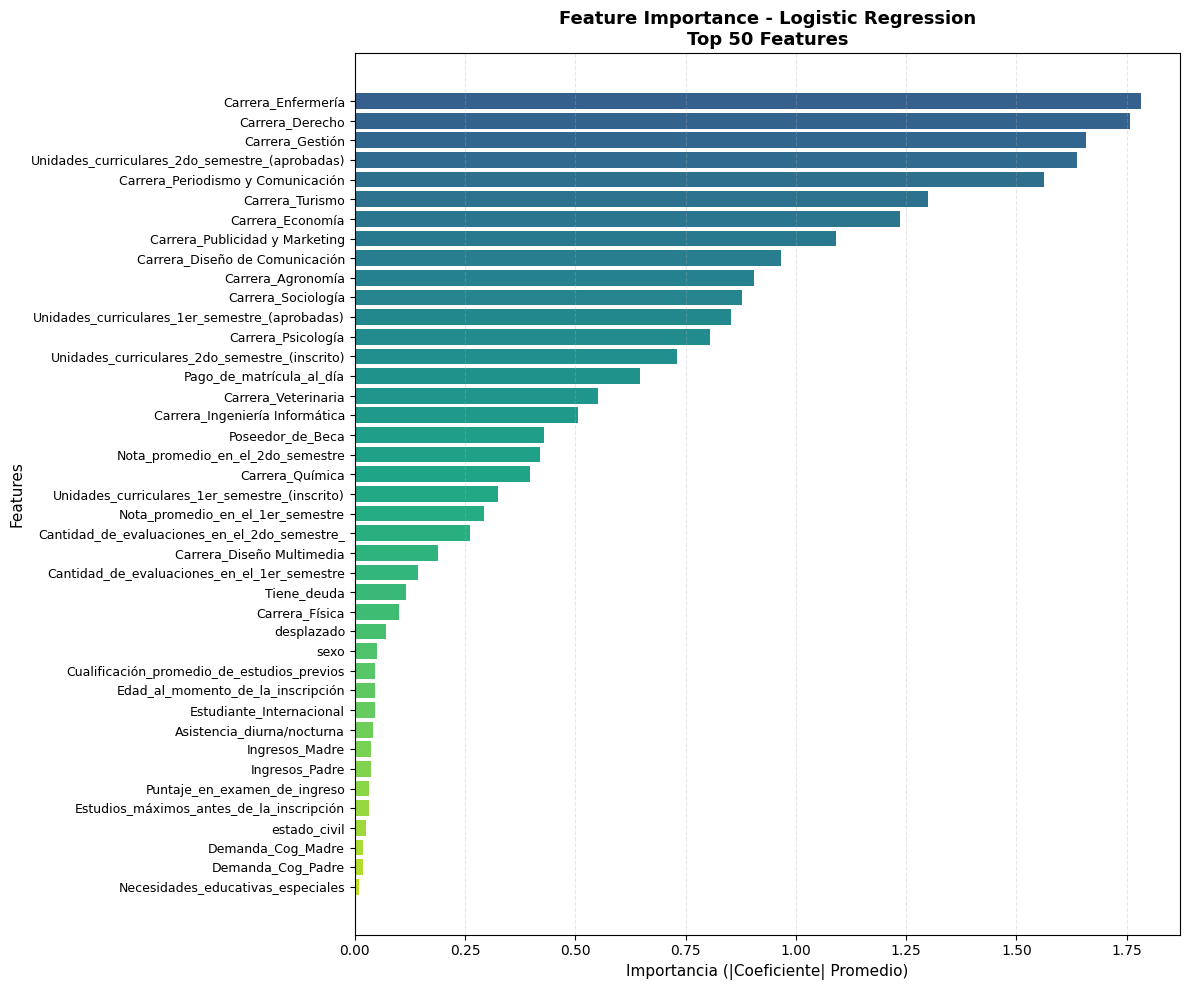


Top 41 Features:
                                       feature  importance
                            Carrera_Enfermería    1.781991
                               Carrera_Derecho    1.758468
                               Carrera_Gestión    1.656942
Unidades_curriculares_2do_semestre_(aprobadas)    1.637405
             Carrera_Periodismo y Comunicación    1.562196
                               Carrera_Turismo    1.299381
                              Carrera_Economía    1.236998
                Carrera_Publicidad y Marketing    1.092083
                Carrera_Diseño de Comunicación    0.967078
                             Carrera_Agronomía    0.905416
                            Carrera_Sociología    0.878583
Unidades_curriculares_1er_semestre_(aprobadas)    0.853544
                            Carrera_Psicología    0.804397
 Unidades_curriculares_2do_semestre_(inscrito)    0.729677
                      Pago_de_matrícula_al_día    0.647234
                           Carrera_Vet

In [47]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_pipeline,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

### Máquina de vectores de soporte (SVM) 

In [48]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42, probability=True))
])

param_grid = {
    'classifier__C': [0.1, 1, 5], 
    'classifier__kernel': ['linear'],  
    'classifier__gamma': ['scale', 'auto'],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred_svm = best_model.predict(X_test)
y_pred_proba_svm = best_model.predict_proba(X_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits



RESULTADOS EN TEST SET - SVM
Accuracy:  0.8563
Precision: 0.8555
Recall:    0.7475
F1-Score:  0.7979
ROC-AUC:   0.9170

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      7137
           1       0.86      0.75      0.80      4365

    accuracy                           0.86     11502
   macro avg       0.86      0.84      0.84     11502
weighted avg       0.86      0.86      0.85     11502



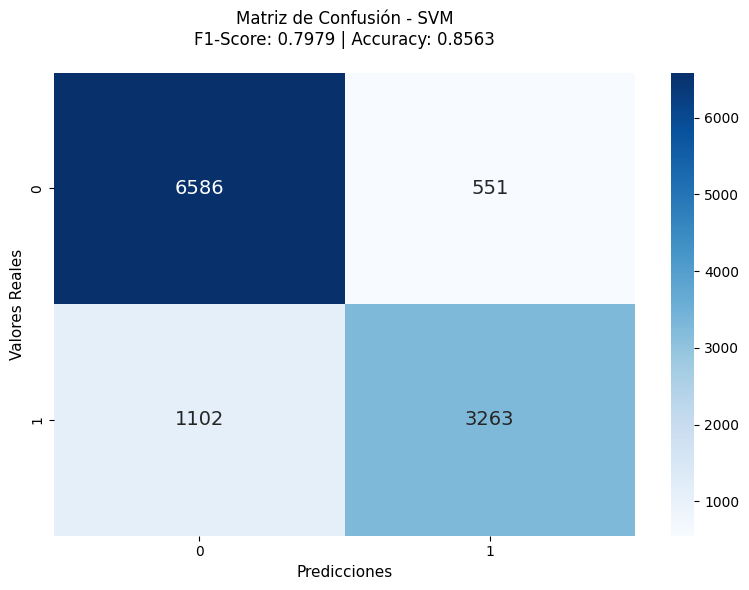

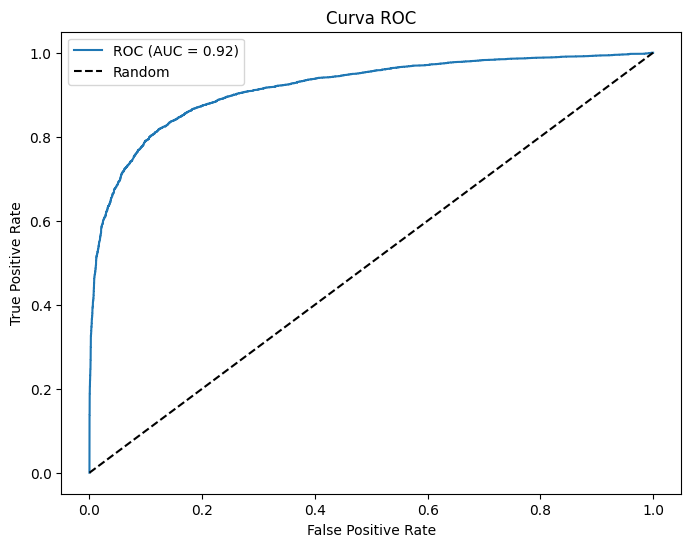

In [49]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred = y_pred_svm, y_pred_proba = y_pred_proba_svm,
                          nombre_modelo="SVM")

In [50]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

Pipeline detectado. Usando: SVC
Modelo multiclase: 2 clases
Clases: [0 1]


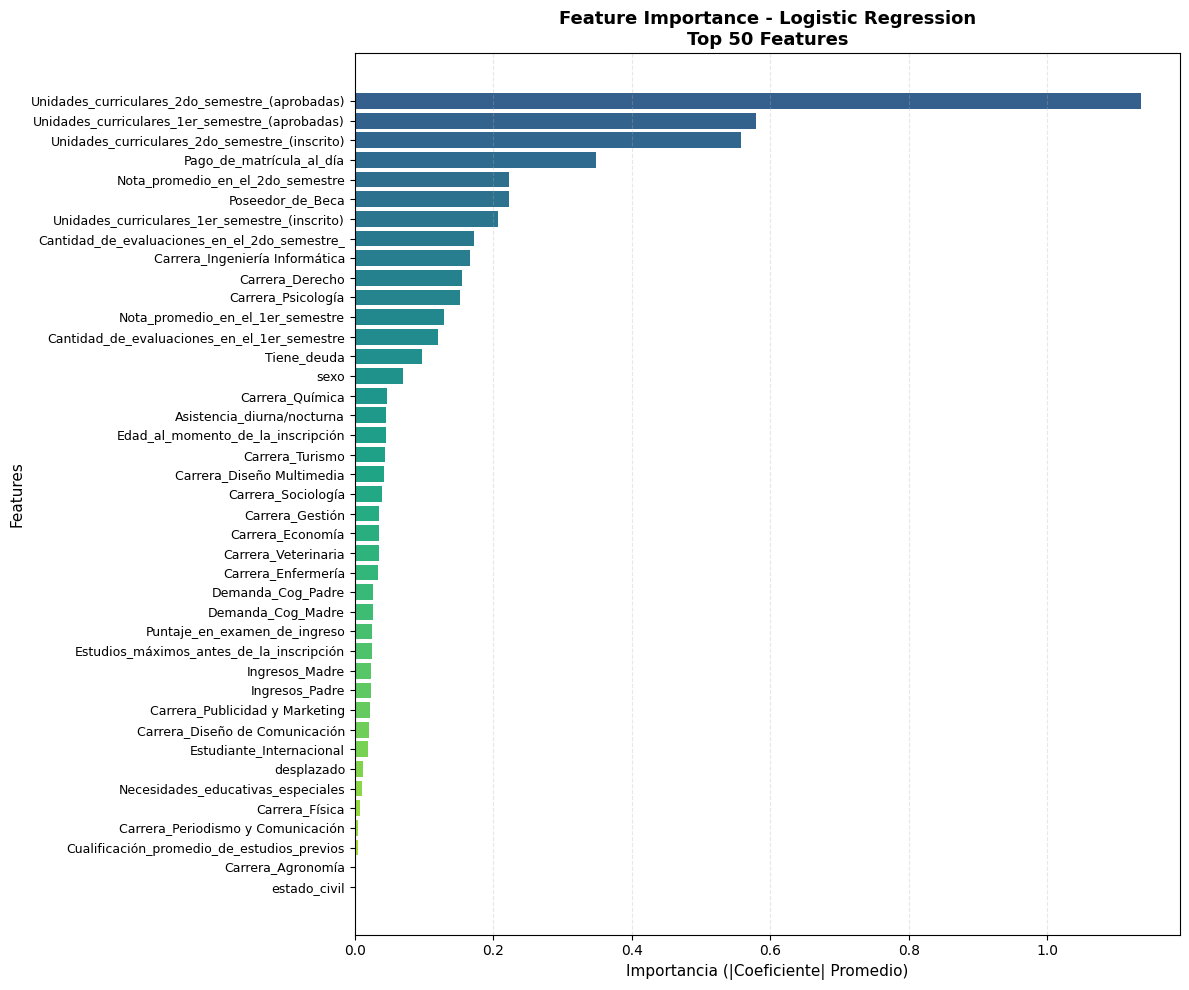


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    1.135178
Unidades_curriculares_1er_semestre_(aprobadas)    0.580031
 Unidades_curriculares_2do_semestre_(inscrito)    0.558092
                      Pago_de_matrícula_al_día    0.349044
              Nota_promedio_en_el_2do_semestre    0.222358
                              Poseedor_de_Beca    0.222227
 Unidades_curriculares_1er_semestre_(inscrito)    0.206987
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.171551
                Carrera_Ingeniería Informática    0.166501
                               Carrera_Derecho    0.154221
                            Carrera_Psicología    0.151932
              Nota_promedio_en_el_1er_semestre    0.128731
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.119549
                                   Tiene_deuda    0.097341
                                          sexo    0.070062
                               Carrera

In [51]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

## KNN

In [52]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': range(3, 21),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits



RESULTADOS EN TEST SET - KNN
Accuracy:  0.8442
Precision: 0.8627
Recall:    0.7010
F1-Score:  0.7735
ROC-AUC:   0.9006

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      7137
           1       0.86      0.70      0.77      4365

    accuracy                           0.84     11502
   macro avg       0.85      0.82      0.83     11502
weighted avg       0.85      0.84      0.84     11502



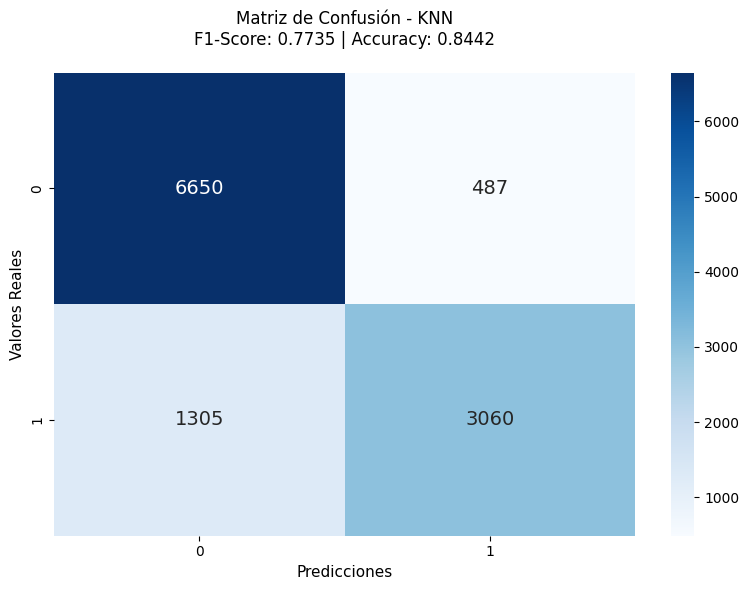

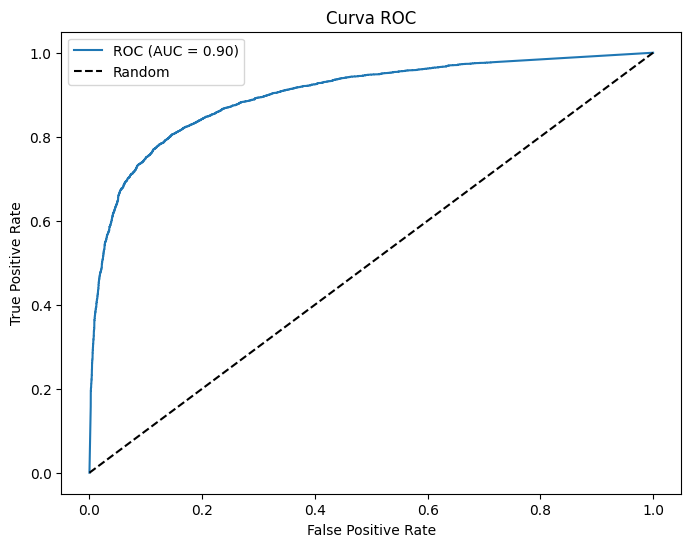

In [53]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="KNN")

In [54]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

### Árboles de Decisión 


In [55]:
# Pipeline para Random Forest
pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parámetros para GridSearch
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced', None]
}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)


# Usar mejor modelo
best_model = grid_search_rf.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits



RESULTADOS EN TEST SET - RANDOM FOREST
Accuracy:  0.8579
Precision: 0.8342
Recall:    0.7805
F1-Score:  0.8065
ROC-AUC:   0.9198

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      7137
           1       0.83      0.78      0.81      4365

    accuracy                           0.86     11502
   macro avg       0.85      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



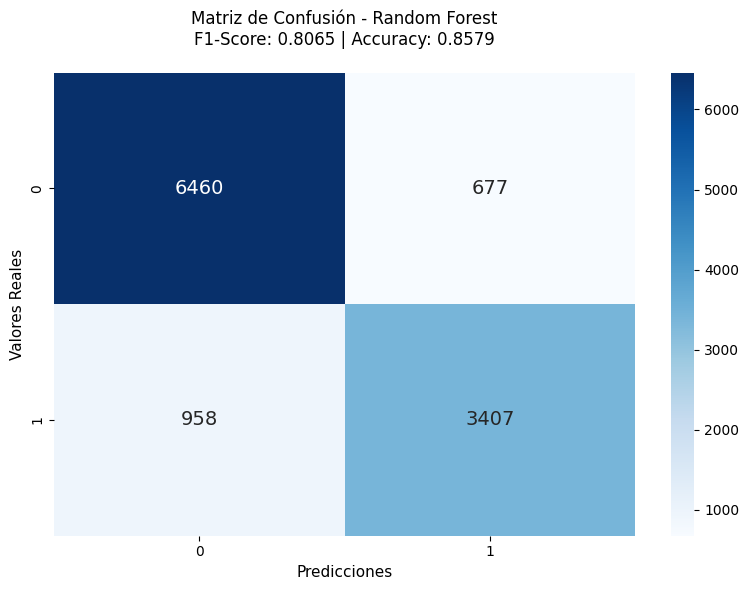

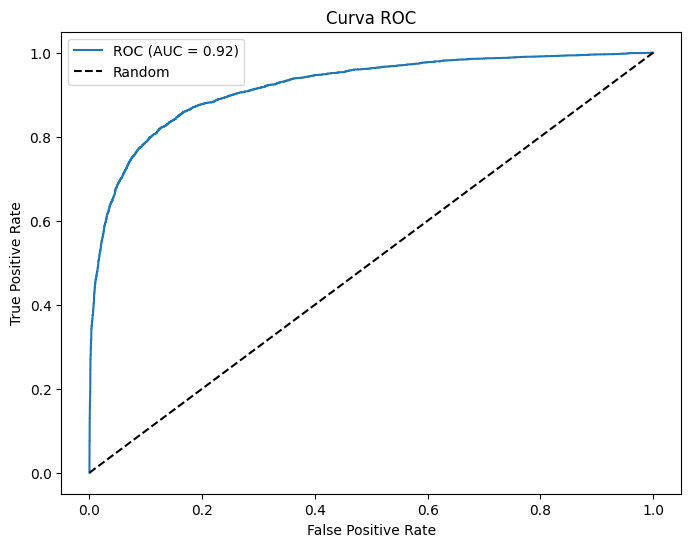

In [56]:
results = analyzer.evaluar_y_guardar_modelo(grid_search_rf, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Random Forest")

In [57]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

Pipeline detectado. Usando: RandomForestClassifier


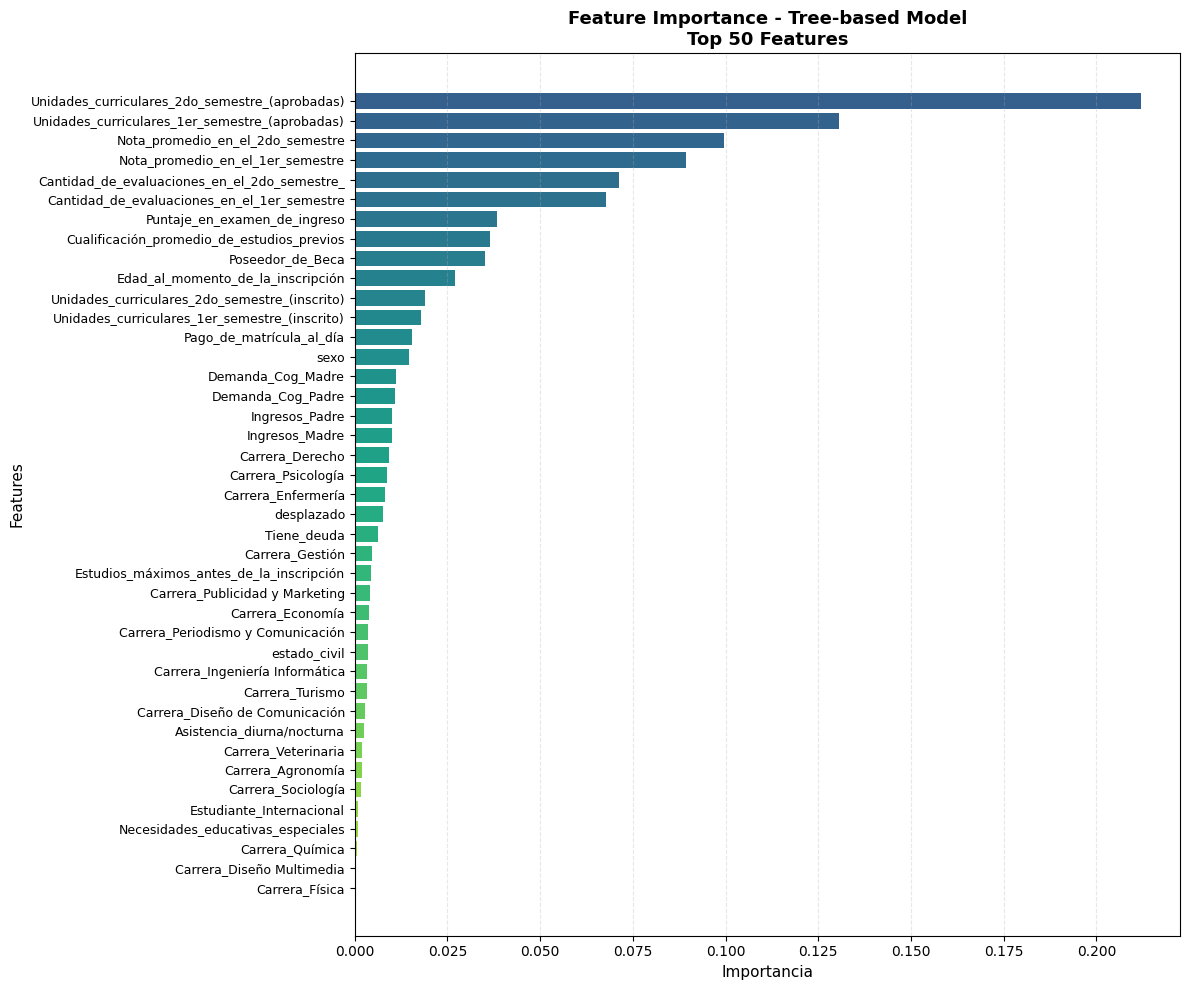


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    0.211924
Unidades_curriculares_1er_semestre_(aprobadas)    0.130440
              Nota_promedio_en_el_2do_semestre    0.099552
              Nota_promedio_en_el_1er_semestre    0.089380
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.071277
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.067635
                  Puntaje_en_examen_de_ingreso    0.038410
    Cualificación_promedio_de_estudios_previos    0.036419
                              Poseedor_de_Beca    0.035124
             Edad_al_momento_de_la_inscripción    0.026926
 Unidades_curriculares_2do_semestre_(inscrito)    0.018944
 Unidades_curriculares_1er_semestre_(inscrito)    0.017990
                      Pago_de_matrícula_al_día    0.015320
                                          sexo    0.014701
                             Demanda_Cog_Madre    0.010998
                             Demanda_C

In [58]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

## Boosting

In [59]:
pipeline = Pipeline([
    ('classifier', lgb.LGBMClassifier(
        objective='binary',
        random_state=42,
        verbose=-1,
        n_jobs=-1
    ))
])


param_grid = {
    'classifier__n_estimators': randint(100, 800),
    'classifier__max_depth': randint(3, 12),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__num_leaves': randint(20, 150),
    'classifier__min_child_samples': randint(10, 100),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(0, 1)
}

grid_search = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=50,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True 
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_samples=31, classifier__n_estimators=408, classifier__num_leaves=21, classifier__reg_alpha=0.7219987722668247, classifier__reg_lambda=0.9385527090157502, classifier__subsample=0.6003115063364057; total time=  13.6s
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_samples=31, classifier__n_estimators=408, classifier__num_leaves=21, classifier__reg_alpha=0.7219987722668247, classifier__reg_lambda=0.9385527090157502, classifier__subsample=0.6003115063364057; total time=  14.1s
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_samples=31, classifier__n_estimators=408, classif


RESULTADOS EN TEST SET - BOOSTING LIGHTGBM 
Accuracy:  0.8622
Precision: 0.8566
Recall:    0.7649
F1-Score:  0.8082
ROC-AUC:   0.9235

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      7137
           1       0.86      0.76      0.81      4365

    accuracy                           0.86     11502
   macro avg       0.86      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



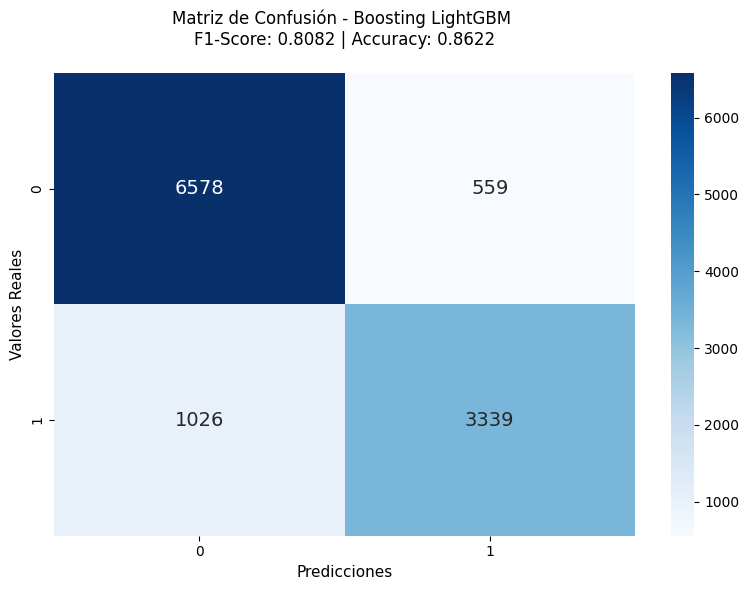

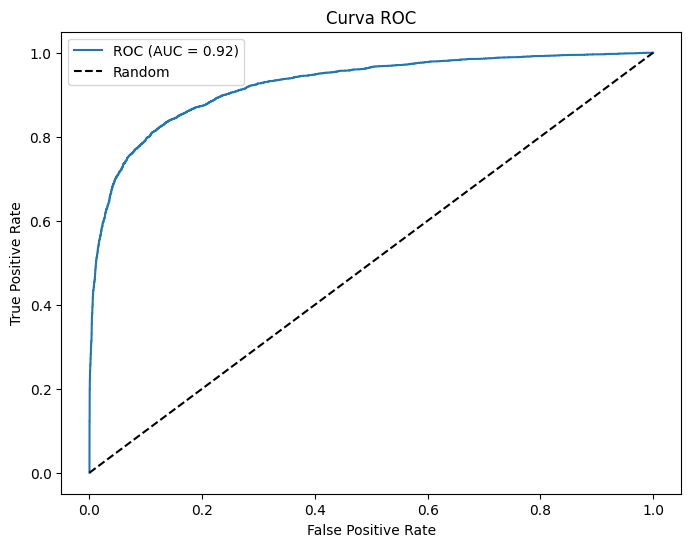

In [60]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Boosting LightGBM ")

In [61]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

Pipeline detectado. Usando: LGBMClassifier


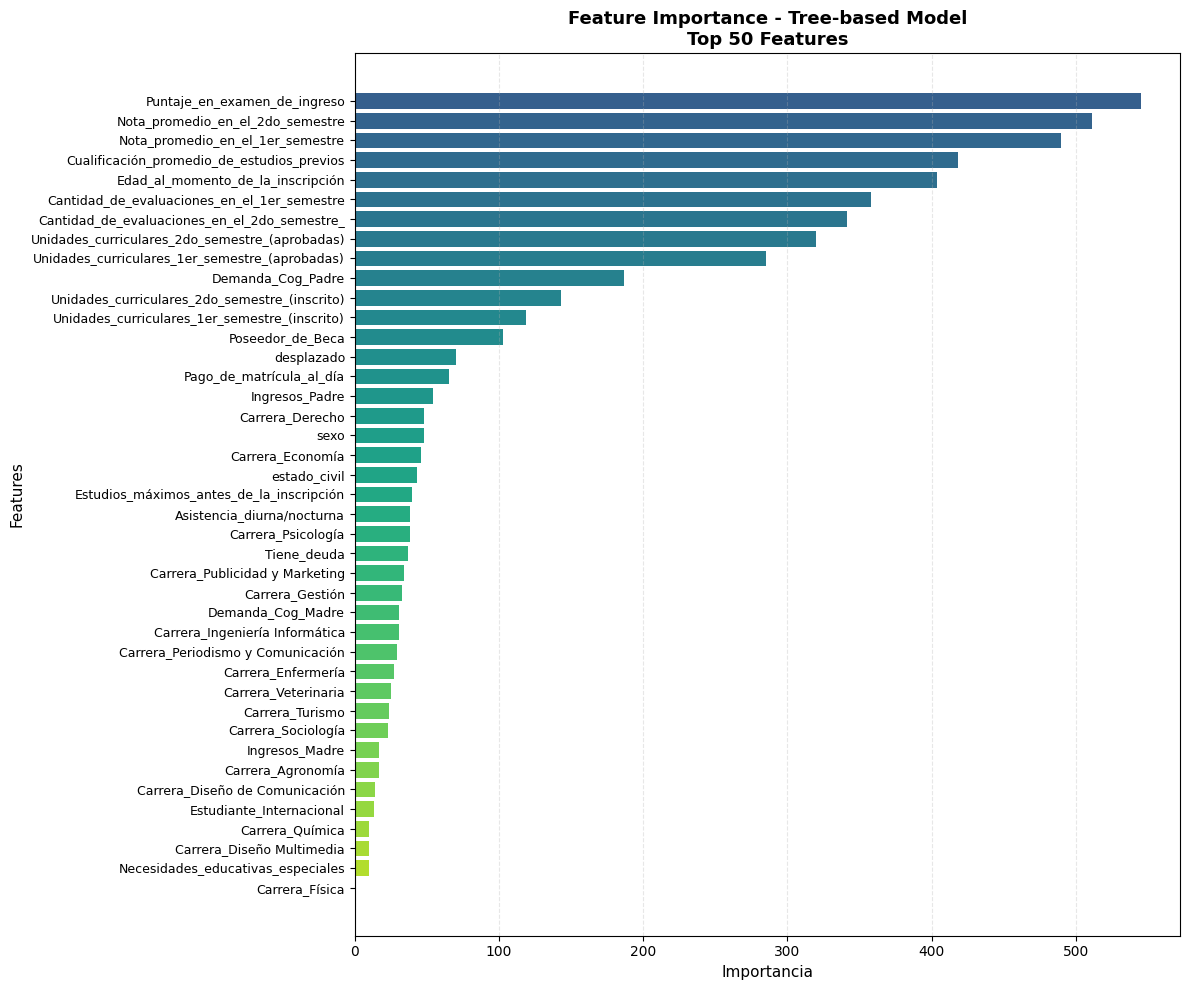


Top 41 Features:
                                       feature  importance
                  Puntaje_en_examen_de_ingreso         545
              Nota_promedio_en_el_2do_semestre         511
              Nota_promedio_en_el_1er_semestre         490
    Cualificación_promedio_de_estudios_previos         418
             Edad_al_momento_de_la_inscripción         404
   Cantidad_de_evaluaciones_en_el_1er_semestre         358
  Cantidad_de_evaluaciones_en_el_2do_semestre_         341
Unidades_curriculares_2do_semestre_(aprobadas)         320
Unidades_curriculares_1er_semestre_(aprobadas)         285
                             Demanda_Cog_Padre         187
 Unidades_curriculares_2do_semestre_(inscrito)         143
 Unidades_curriculares_1er_semestre_(inscrito)         119
                              Poseedor_de_Beca         103
                                    desplazado          70
                      Pago_de_matrícula_al_día          65
                                Ingres

In [62]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

## Optuna para RF

In [63]:
def objective(trial):
    # Definimos el espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    # Definir el modelo
    modelo = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    # Calcular accuracy
    acc = accuracy_score(y_test, y_pred)
    return acc

# Crear el estudio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Mostrar los mejores parámetros y el mejor score
print("Mejores hiperparámetros:", study.best_params)
print("Mejor accuracy:", study.best_value)

[I 2025-10-17 16:05:12,836] A new study created in memory with name: no-name-2770405a-89f2-46ab-9ba2-fe010e081a4d
[I 2025-10-17 16:05:14,912] Trial 0 finished with value: 0.8441140671187619 and parameters: {'n_estimators': 213, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 0.8441140671187619.
[I 2025-10-17 16:05:15,333] Trial 1 finished with value: 0.8454181881411929 and parameters: {'n_estimators': 123, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.8454181881411929.
[I 2025-10-17 16:05:16,150] Trial 2 finished with value: 0.8516779690488611 and parameters: {'n_estimators': 52, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 2 with value: 0.8516779690488611.
[I 2025-10-17 16:05:20,620] Trial 3 finished with value: 0.8526343244653104 and parameters: {'n_estimators': 272, 'max_depth': 9, 'min_samp

Mejores hiperparámetros: {'n_estimators': 62, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}
Mejor accuracy: 0.858981046774474


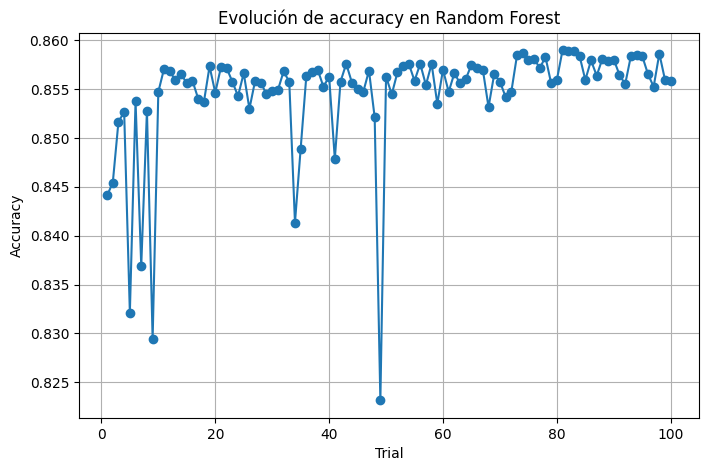

In [64]:
# Extraer los valores de accuracy de cada trial
accuracies = [t.value for t in study.trials]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies)+1), accuracies, marker='o')
plt.title("Evolución de accuracy en Random Forest")
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## VOTING

In [65]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=42, class_weight=None, max_iter=10000, C= 1, penalty= 'l2', solver= 'saga'))])

pipe_svm = Pipeline([('svm', SVC(probability=True, random_state=42, kernel='linear', C=1, gamma= 'scale'))])

pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_neighbors= 20, weights= 'uniform', metric= 'manhattan'))])

pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=42, n_estimators=100, class_weight=None,  max_depth= 20, min_samples_split= 5))])

pipe_lgbm = Pipeline([('lgbm', lgb.LGBMClassifier(random_state=42, objective='binary', verbose=-1, n_jobs=-1, colsample_bytree= np.float64(0.8428136990746738), learning_rate= np.float64(0.06519983640450867), max_depth= 3, min_child_samples= 98, n_estimators= 620, num_leaves= 107, reg_alpha= np.float64(0.3948815181755697), reg_lambda= np.float64(0.2934881747180381), subsample= np.float64(0.6056319290860338)))])


voting_clf = VotingClassifier(
    estimators=[
        ('lr', pipe_lr),            
        ('svm', pipe_svm),
        ('knn', pipe_knn),
        ('rf', pipe_rf),
        ('lgbm', pipe_lgbm)], voting='hard')    #SOFT PARA PREDICCIÓN DE PROBA. HARD PARA PREDICCIÓN DE CLASE.


#voting concatena la información de todas las salidas para predecir.
voting_clf.fit(X_train_scaled, y_train)

,estimators,"[('lr', ...), ('svm', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True


In [67]:
print(f"Accuracy training : {voting_clf.score(X_train_scaled, y_train):.3f}")
print(f"Accuracy test: {voting_clf.score(X_test_scaled, y_test):.3f}")

Accuracy training : 0.871
Accuracy test: 0.860


VOTING CLASSIFIER - RESULTADO FINAL
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      7137
           1       0.86      0.75      0.80      4365

    accuracy                           0.86     11502
   macro avg       0.86      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



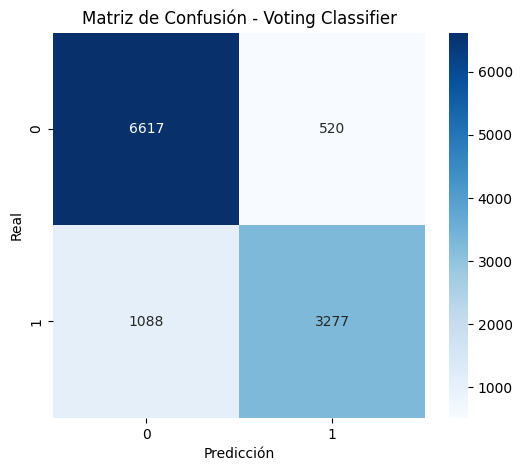

In [68]:
# Predicciones del voting classifier
y_pred_voting = voting_clf.predict(X_test_scaled)

print("VOTING CLASSIFIER - RESULTADO FINAL")
print("="*60)
print(classification_report(y_test, y_pred_voting))

# Matriz de confusión
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Voting Classifier')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()